<a href="https://colab.research.google.com/github/dgiri4132/QuantRiskEngine/blob/main/QuantRiskEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
n=int(input('Enter the number of stocks: '))
tickers = [input(f"Enter ticker {i+1}: ").upper().strip() for i in range(n)]
start_date=input('Enter start date (YYYY-MM-DD): ')
end_date=input('Enter end date (YYYY-MM-DD): ')
df=yf.download(tickers,start=start_date,end=end_date, auto_adjust=False)['Adj Close'].dropna()
returns=df.pct_change().dropna()

Enter the number of stocks: 3
Enter ticker 1: amzn
Enter ticker 2: aapl
Enter ticker 3: axp
Enter start date (YYYY-MM-DD): 2024-01-01
Enter end date (YYYY-MM-DD): 2025-01-01


[*********************100%***********************]  3 of 3 completed


In [2]:
#First Major Risk Metric(VaR)
from scipy.stats import norm
from scipy.stats import t
portfolio_returns=returns.mean(axis=1)
confidence_level=0.95
alpha=1-confidence_level
historical_VaR=np.quantile(portfolio_returns,alpha)
print(f'Historical VaR(95%): {historical_VaR:.4f}')
mean_p=portfolio_returns.mean()
std_p=portfolio_returns.std()
param_VaR=norm.ppf(alpha,mean_p,std_p)
print(f'Parametric VaR (Normal, 95%): {param_VaR:.4f}')
params_t=t.fit(portfolio_returns)
t_VaR=t.ppf(alpha,*params_t)
print(f'Parametric VaR (t-test,95%): {t_VaR:.4f}')

Historical VaR(95%): -0.0173
Parametric VaR (Normal, 95%): -0.0169
Parametric VaR (t-test,95%): -0.0156


In [3]:
#CVaR metrics
from scipy.stats import norm,t
historical_CVaR=portfolio_returns[portfolio_returns<=historical_VaR].mean()
print(f'Historical CVaR(95%): {historical_CVaR:.4f}')
param_CVaR=(1/alpha)*norm.expect(lambda x:x,loc=mean_p,scale=std_p,lb=-np.inf,ub=param_VaR)
print(f'Parametric CVaR(Normal,95%): {param_CVaR:.4f}')
df, loc,scale=params_t
t_CVaR=(1/alpha)*t.expect(lambda x:x, args=(df,), loc=loc,scale=scale,lb=-np.inf,ub=t_VaR)
print(f'Parametric CVaR(t-test,95%): {t_CVaR:.4f}')

Historical CVaR(95%): -0.0261
Parametric CVaR(Normal,95%): -0.0216
Parametric CVaR(t-test,95%): -0.0241


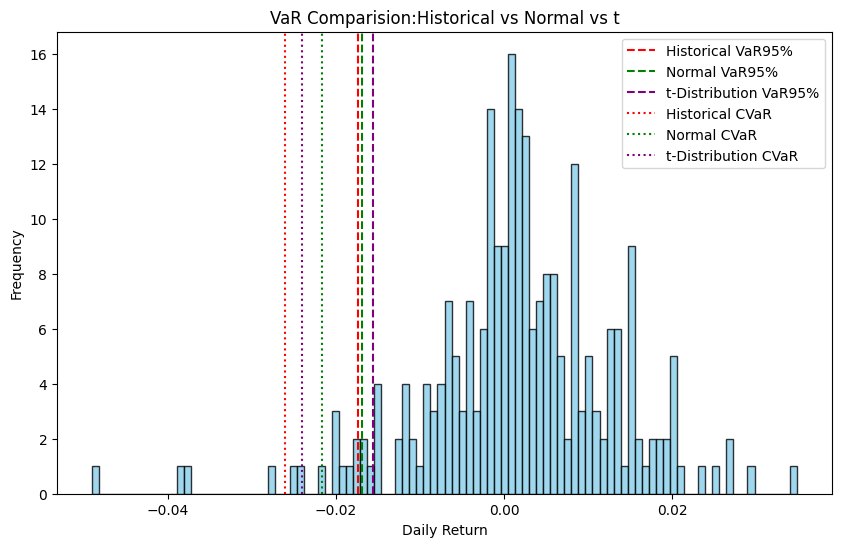

In [4]:
#Plots of all six VaR metrics
plt.figure(figsize=(10,6))
plt.hist(portfolio_returns,bins=100,color='skyblue',alpha=0.8, edgecolor='black')
plt.axvline(historical_VaR,color='red',linestyle='--',label='Historical VaR95%')
plt.axvline(param_VaR,color='green',linestyle='--',label='Normal VaR95%')
plt.axvline(t_VaR,color='purple',linestyle='--',label='t-Distribution VaR95%')
plt.axvline(historical_CVaR, color='red', linestyle=':', label='Historical CVaR')
plt.axvline(param_CVaR, color='green', linestyle=':', label='Normal CVaR')
plt.axvline(t_CVaR, color='purple', linestyle=':', label='t-Distribution CVaR')
plt.title('VaR Comparision:Historical vs Normal vs t')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [6]:
#Monte Carlo simulation experiment
from scipy.stats import norm
import numpy as np
mu=portfolio_returns.mean()
sigma=portfolio_returns.std()
total_steps=390*60
N=int(input('Enter the number of simulations(more is better but longer time to process): '))
simulated_daily_returns=np.zeros(N)
for i in range(N):
  indp_path=norm.rvs(loc=mu/total_steps,scale=sigma/np.sqrt(total_steps),size=total_steps)
  simulated_daily_returns[i]=indp_path.sum()
alpha=0.05
mc_VaR=np.quantile(simulated_daily_returns,alpha)
print(f'Monte Carlo VaR(95%): {mc_VaR:.4f}')
mc_CVaR=np.mean(simulated_daily_returns[simulated_daily_returns<=mc_VaR])
print(f'Monte Carlo CVaR(95%): {mc_CVaR:.4f}')


Enter the number of simulations(more is better but longer time to process): 10000
Monte Carlo VaR(95%): -0.0171
Monte Carlo CVaR(95%): -0.0216


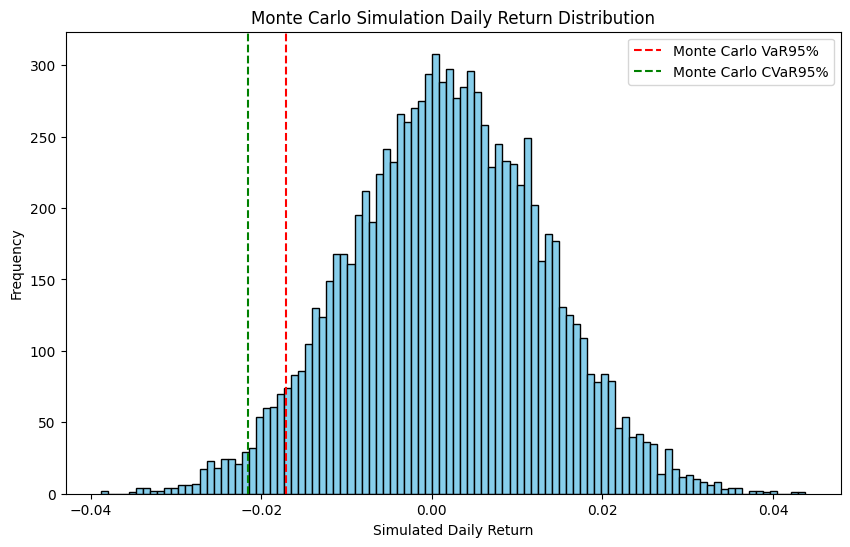

In [7]:
#Monte-Carlo visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(simulated_daily_returns,bins=100,color='skyblue',edgecolor='black')
plt.axvline(mc_VaR,color='red',linestyle='--',label='Monte Carlo VaR95%')
plt.axvline(mc_CVaR,color='green',linestyle='--',label='Monte Carlo CVaR95%')
plt.title('Monte Carlo Simulation Daily Return Distribution')
plt.xlabel('Simulated Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [13]:
#Extreme Value Theory(Block Maxima and Generalized Extreme Value Distribution)
from scipy.stats import genextreme
weekly_maxima=portfolio_returns.resample('W').min()
gev_params=genextreme.fit(weekly_maxima)
confidence_level=0.99
alpha=1-confidence_level
shape,loc,scale=gev_params
VaR_99_evt=genextreme.ppf(alpha,c=shape,loc=loc,scale=scale)
CVaR_99_evt=(1/alpha)*genextreme.expect(lambda x:x,args=(shape,),loc=loc,scale=scale,lb=-np.inf,ub=VaR_99_evt)
print(f'EVT-based VaR(99%): {VaR_99_evt:.4f}')
print(f'EVT-based CVaR(99%): {CVaR_99_evt:.4f}')

EVT-based VaR(99%): -0.0463
EVT-based CVaR(99%): -0.0543


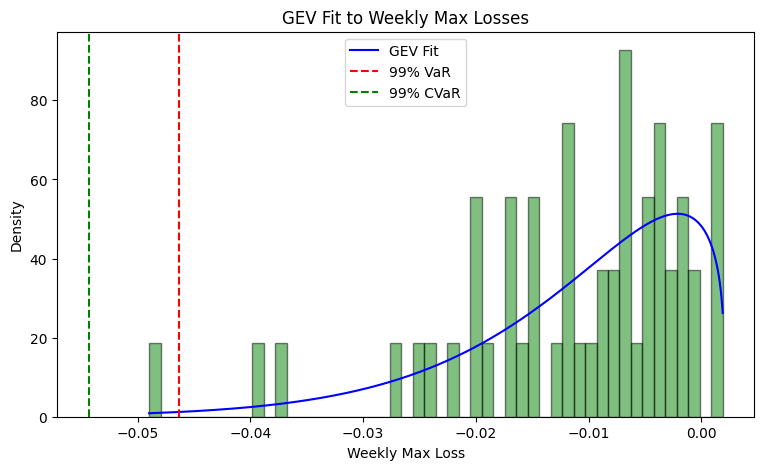

In [15]:
#GEV visualization
import matplotlib.pyplot as plt
import numpy as np
x_vals=np.linspace(min(weekly_maxima),max(weekly_maxima),1000)
gev_pdf=genextreme.pdf(x_vals,*gev_params)
plt.figure(figsize=(9,5))
plt.plot(x_vals,gev_pdf,label='GEV Fit',color='blue')
plt.axvline(VaR_99_evt,color='red',linestyle='--',label='99% VaR')
plt.axvline(CVaR_99_evt,color='green',linestyle='--',label='99% CVaR')
plt.hist(weekly_maxima,bins=50,density=True,alpha=0.5,color='green',edgecolor='black')
plt.title('GEV Fit to Weekly Max Losses')
plt.xlabel('Weekly Max Loss')
plt.ylabel('Density')
plt.legend()
plt.show()